# Generative Adversarial Network (GAN)

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from tqdm import tqdm
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
def accuracy(net, dl):
    acc = 0.
    for x,t in dl:
        y = net(x)
        k = torch.argmax(y, dim=-1)
        acc += torch.sum(k==t)
    return acc.item() / len(dl.dataset)

In [3]:
# PyTorch 1.7 includes a layer called Unflatten, which undoes what Flatten does.
# If your torch version is <1.7, then you can use this class in its place.
class Unflatten(nn.Module):
    '''
     Unflatten(dim, unflatten_size)
     
     Reshapes a DxN tensor to Dx(*unflatten_size).
     The first argument, dim, is actually IGNORED, but is included here
     for compatibility with nn.Unflatten.
     
     Usage:
       x = torch.random(10,50)  # x is 10x50
       lyr = Unflatten(1, (2,5,5))
       y = lyr(x)   # produces y with dimensions (10,2,5,5)
    '''
    def __init__(self, dim, shape):
        super().__init__()
        self.start_dim = dim
        self.shape = shape
        
    def forward(self, x):
        return torch.reshape(x, (x.shape[0], *self.shape))

# Dataset

In [194]:
# Use this for fully-connected network
ds_train_full = torchvision.datasets.MNIST('./files/', train=True, download=True,
                            transform=torchvision.transforms.Compose([
                            torchvision.transforms.ToTensor(),
                            torchvision.transforms.Normalize((0.5,),(0.5,)),
                            torchvision.transforms.Lambda((lambda x: torch.flatten(x))),
                            ]))

In [225]:
# Use this for CNN
# ds_train_full = torchvision.datasets.MNIST('./files/', train=True, download=True,
#                             transform=torchvision.transforms.Compose([
#                             torchvision.transforms.ToTensor(),
#                             torchvision.transforms.Normalize((0.5,),(0.5,)),
#                             ]))

## Process

In [195]:
#ds_train = torch.utils.data.Subset(ds_train_full, range(5000))
ds_train = ds_train_full

In [196]:
x,t = ds_train.__getitem__(0)

In [197]:
def draw(X):
    img_size = 28
    def draw_single(x): 
        with torch.no_grad():
            plt.imshow(x.detach().cpu().numpy().reshape((img_size, img_size)), cmap='gray');
            plt.axis('off');
    if len(X.shape)==4 or len(X.shape)==2:  # display a batch
        N = X.shape[0]
        plt.figure(figsize=(15,3))
        for k,xx in enumerate(X):
            plt.subplot(1,10,k+1)
            draw_single(xx)
    else:
        draw_single(X)

In [198]:
# Batched, for training
batch_size_train = 32
train_dl = torch.utils.data.DataLoader(ds_train, batch_size=batch_size_train, shuffle=True)

In [199]:
x,t = next(iter(train_dl))
print(x.shape)
print(t)

torch.Size([32, 784])
tensor([9, 1, 1, 5, 7, 4, 4, 8, 9, 2, 1, 6, 1, 0, 8, 4, 1, 0, 3, 5, 1, 2, 0, 0,
        9, 5, 3, 0, 9, 9, 3, 3])


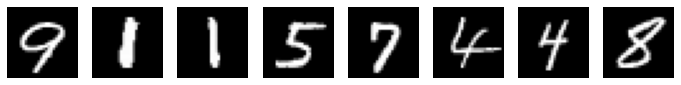

In [200]:
draw(x[:8])

# GAN classes

## CNN GAN
This CNN GAN does not work for some reason. It trains, etc, but does not generate digit-like images.

In [226]:
# class gan(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.z_dim = 100
#         self.losses_D = []
#         self.losses_G = []
        
#         # D: Convolution part of the discriminator
#         self.D = nn.Sequential(
#             nn.Conv2d(1, 64, 3), nn.ReLU(),
#             nn.Conv2d(64, 128, 3), nn.ReLU(),
#             nn.Conv2d(128, 64, 3), nn.ReLU(),
#             nn.Flatten(start_dim=1),
#         )
        
#         # Dhead: Output of the discriminator, Dhead
#         blah = torch.zeros((3, 1, 28, 28))
#         pen_dim = self.D(blah).shape[-1]
#         self.Dhead = nn.Sequential(nn.Linear(pen_dim, 1), nn.Sigmoid())
        
#         # Discriminator: D -> Dhead
#         self.Discriminator = nn.Sequential(self.D, self.Dhead)
        
#         # G: Generator
#         self.G = nn.Sequential(
#             nn.Linear(self.z_dim, pen_dim),
#             Unflatten(-1, (64,22,22)), nn.ReLU(),  # can use Unflatten, defined above
#             nn.ConvTranspose2d(64, 128, 3), nn.ReLU(),
#             nn.ConvTranspose2d(128, 64, 3), nn.ReLU(),
#             nn.ConvTranspose2d(64, 1, 3), nn.Tanh(),
#         )
        
#         self.D_loss_fcn = nn.BCELoss()
#         self.G_loss_fcn = nn.BCELoss()
#         self.to(device)
                
#     def forward(self, x):
#         return self.discriminate(x)
    
#     def discriminate(self, x):
#         '''
#          y = net.discriminate(x)
         
#          Runs the discriminative network on a batch of inputs.
         
#          Inputs:
#           x   [D,<input shape>] batch of inputs
#               where <input shape> is [1,28,28]
          
#          Outputs:
#           y   Dx1 batch of outputs
#         '''
#         #z = self.D(x)
#         return self.Discriminator(x).squeeze()
        
#     def generate(self, n=1):
#         '''
#          y = net.generate(n=1)
         
#          Generates a batch of n inputs using random latent-vector seeds.
         
#          Inputs:
#           n   number of inputs to generate
          
#          Outputs:
#           y   [n,<input shape>] batch of generated inputs
#               where <input shape> is [1,28,28]
#         '''
#         z = torch.normal(torch.zeros((n,self.z_dim,)), 1.).to(device)
#         return self.G(z)
        
#     def learn(self, dl, epochs=10, lr=0.0001):
#         optim_D = torch.optim.Adam(self.Discriminator.parameters(), lr=lr)
#         optim_G = torch.optim.Adam(self.G.parameters(), lr=lr*2.)
#         for epoch in tqdm(range(epochs)):
#             total_D_loss = 0.
#             total_G_loss = 0.
#             for x,t in dl:
#                 x = x.to(device)
#                 t = t.to(device)
#                 bs = len(t)
                
#                 # Generate some inputs
#                 z = torch.normal(torch.zeros((bs, self.z_dim)), 1.).to(device) # seeds
#                 x_gen = self.G(z)  # This is the FF pass of the Generator!
                
#                 # Concat. legit and generated samples together into 1 batch
#                 x_both = torch.cat((x, x_gen))
#                 t_both = torch.cat( ( torch.ones((bs,)), torch.zeros((bs,)) ) ).to(device)
                
#                 # FF pass on the Discriminator
#                 y = self.discriminate(x_both)
                
#                 # Discriminator loss (for both true and generated inputs)
#                 loss_D = self.D_loss_fcn(y, t_both)
                
#                 # Gradient step for Discriminator
#                 optim_D.zero_grad()
#                 loss_D.backward()
#                 optim_D.step()
                
#                 # Generator loss
#                 # (just process the fake images made by the generator)
#                 # Just like creating an adversarial input, we choose the target
#                 # we want (t=1), and push the gradient down through the network.
#                 z = torch.normal(torch.zeros((bs, self.z_dim)), 1.).to(device) # seeds
#                 y_gen = self.discriminate( self.G(z) ) # FF through both networks z->G->D->y
#                 loss_G = self.G_loss_fcn(y_gen, torch.ones((len(z),)).to(device) )
#                 optim_G.zero_grad()
#                 loss_G.backward()
#                 optim_G.step()
                
#                 total_D_loss += loss_D.item()*len(t)
#                 total_G_loss += loss_G.item()*len(t)
#             self.losses_D.append(total_D_loss/len(dl.dataset))
#             self.losses_G.append(total_G_loss/len(dl.dataset))
#         plt.plot(self.losses_D); plt.plot(self.losses_G);
#         plt.legend(['Disc.', 'Gen.']);
#         plt.xlabel('Epochs'); plt.yscale('log');

## Fully-connected GAN

In [241]:
class gan(nn.Module):
    def __init__(self):
        super().__init__()
        self.z_dim = 100
        self.losses_D = []
        self.losses_G = []
        self.D = nn.Sequential(
            nn.Linear(784, 256), nn.ReLU(),
            nn.Linear(256, 128), nn.ReLU(),
            nn.Linear(128, 1), nn.Sigmoid(),
        )
        self.Discriminator = self.D
        
        self.G = nn.Sequential(
            nn.Linear(self.z_dim, 128), nn.ReLU(),
            nn.Linear(128, 256), nn.ReLU(),
            nn.Linear(256, 784), nn.Tanh(),
        )
        self.D_loss_fcn = nn.BCELoss()
        self.G_loss_fcn = nn.MSELoss()
        self.to(device)
                
    def forward(self, x):
        return self.discriminate(x)
    
    def discriminate(self, x):
        '''
         y = net.discriminate(x)
         
         Runs the discriminative network on a batch of inputs.
         
         Inputs:
          x   [D,<input shape>] batch of inputs
              where <input shape> is [1,28,28]
          
         Outputs:
          y   Dx1 batch of outputs
        '''
        #z = self.D(x)
        return self.Discriminator(x).squeeze()
        
    def generate(self, n=1):
        '''
         y = net.generate(n=1)
         
         Generates a batch of n inputs using random latent-vector seeds.
         
         Inputs:
          n   number of inputs to generate
          
         Outputs:
          y   [n,<input shape>] batch of generated inputs
              where <input shape> is [1,28,28]
        '''
        z = torch.normal(torch.zeros((n,self.z_dim,)), 1.).to(device)
        return self.G(z)
        
    def learn(self, dl, epochs=10, lr=0.0001):
        optim_D = torch.optim.Adam(self.Discriminator.parameters(), lr=lr)
        optim_G = torch.optim.Adam(self.G.parameters(), lr=lr*2.)
        for epoch in tqdm(range(epochs)):
            total_D_loss = 0.
            total_G_loss = 0.
            for x,t in dl:
                x = x.to(device)
                t = t.to(device)
                bs = len(t)
                
                # Generate some inputs
                z = torch.normal(torch.zeros((bs, self.z_dim)), 1.).to(device) # seeds
                x_gen = self.G(z)  # This is the FF pass of the Generator!
                
                # Concat. legit and generated samples together into 1 batch
                x_both = torch.cat((x, x_gen))
                t_both = torch.cat( ( torch.ones((bs,)), torch.zeros((bs,)) ) ).to(device)
                
                # FF pass on the Discriminator
                y = self.discriminate(x_both)
                
                # Discriminator loss (for both true and generated inputs)
                loss_D = self.D_loss_fcn(y, t_both)
                
                # Gradient step for Discriminator
                optim_D.zero_grad()
                loss_D.backward()
                optim_D.step()
                
                # Generator loss
                # (just process the fake images made by the generator)
                # Just like creating an adversarial input, we choose the target
                # we want (t=1), and push the gradient down through the network.
                z = torch.normal(torch.zeros((bs, self.z_dim)), 1.).to(device) # seeds
                y_gen = self.discriminate( self.G(z) ) # FF through both networks z->G->D->y
                loss_G = self.G_loss_fcn(y_gen, torch.ones((len(z),)).to(device) )
                optim_G.zero_grad()
                loss_G.backward()
                optim_G.step()
                
                total_D_loss += loss_D.item()*len(t)/2.
                total_G_loss += loss_G.item()*len(t)
            self.losses_D.append(total_D_loss/len(dl.dataset))
            self.losses_G.append(total_G_loss/len(dl.dataset))
        plt.plot(self.losses_D); plt.plot(self.losses_G);
        plt.legend(['Disc.', 'Gen.']);
        plt.xlabel('Epochs'); plt.yscale('log');

# Train it and test it

In [244]:
net = gan()

100%|██████████| 100/100 [39:21<00:00, 23.62s/it]


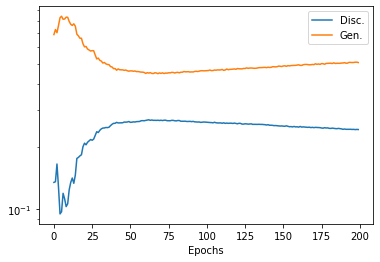

In [249]:
net.learn(train_dl, epochs=100, lr=0.0001)

In [246]:
torch.save(net.to('cpu'), 'gan_demo.pt')
#net = torch.load('gan_demo.pt', map_location=device); net.to(device);
#net = torch.load('gan_cnn_demo.pt', map_location=device); net.to(device);
net.to(device);

torch.Size([32])
[0.87911636 0.6457723  0.87087053 0.67984164 0.3914534  0.9896779
 0.8845119  0.552361   0.8099795  0.5415538  0.8526529  0.95917773
 0.46150324 0.54091054 0.686423   0.6420749  0.6919861  0.42834827
 0.99753016 0.20901029 0.3169175  0.29239756 0.11190544 0.6477268
 0.85505885 0.88150245 0.73799425 0.5639454  0.48756695 0.949184
 0.8348568  0.53331405]


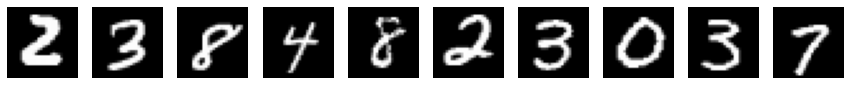

In [250]:
x,t = next(iter(train_dl))
y = net.discriminate(x.to(device))
print(y.shape)
draw(x[:10]);
print(f'{y.detach().cpu().numpy()}')

tensor([0.3074, 0.3286, 0.0146, 0.5630, 0.2213, 0.2838, 0.2459, 0.3860, 0.3628,
        0.0313], device='cuda:0', grad_fn=<SqueezeBackward0>)


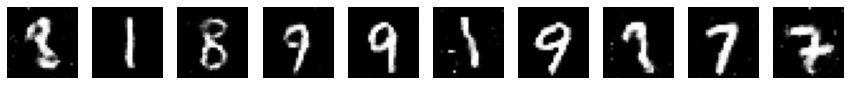

In [251]:
x = net.generate(n=10).to(device)
y = net(x)
draw(x[:10])
print(y)